# Full Graph Construction

In [1]:
#%matplotlib widget
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

# Tiling of Picture

In [2]:
# DATA
from PIL import Image
import numpy as np
i = 2
from src.datasets.MoNuSeg import MoNuSeg
from src.datasets.PanNuke import PanNuke
from src.transforms.image_processing.augmentation import Normalize



ds_mon = MoNuSeg(os.path.join(parent,"data","processed","MoNuSeg_TRAIN"))
sample = ds_mon[i]
img_orig,sm_gt,ins_gt = sample["image"].clone(),sample["semantic_mask"].clone(),sample["instance_mask"].clone()
t_img = Normalize(
        {"image": [0.6441, 0.4474, 0.6039]},
        {"image": [0.1892, 0.1922, 0.1535]})(sample)['image']

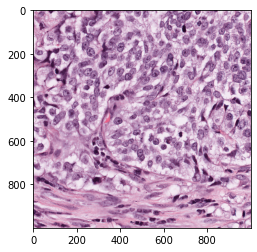

In [3]:
import matplotlib.pyplot as plt

from src.utilities.img_utilities import tensor_to_numpy

plt.imshow(tensor_to_numpy(img_orig))
plt.show()

In [4]:
# MODEL
from src.model.architectures.graph_construction.hover_net import HoVerNet
chkpt = "HoVerNet_MD-1.1.ckpt"
chkpt_path = os.path.join(parent,"experiments","checkpoints",chkpt)

model = HoVerNet.load_from_checkpoint(chkpt_path, RESNET_SIZE=50,START_LR=0)

In [5]:
import torch
from torchvision.transforms import ToTensor

from tqdm import tqdm


def predict_full_image(model, img,tile_size=32): # times 2, ensures that an whole number of tiles fit in the image
    model.eval()
    model.cuda()
    assert tile_size%2==0
    
    #ENSURE WHOLE NUMBER OF TILES FIT
    dim = list(img.shape[1:])
    dim[0] = dim[0]//tile_size*tile_size
    dim[1] = dim[1]//tile_size*tile_size
    img = img[:,:dim[0],:dim[1]]

    
    final_sm = torch.zeros(dim[0]-tile_size,dim[1]-tile_size)
    final_hv_x = torch.zeros(dim[0]-tile_size,dim[1]-tile_size)
    final_hv_y = torch.zeros(dim[0]-tile_size,dim[1]-tile_size)
    
    batch_size = 20//((2*tile_size//64)*(2*tile_size//64))
    print(batch_size)
    batch = None
    batch_loc = []
    
    def add_tiles(batch,batch_loc):
        with torch.no_grad():
            (sm,hv) = model(batch.cuda())
            sm_b,hv_b = sm.cpu(),hv.cpu()
            for (r,c),sm,hv in zip(batch_loc,sm_b,hv_b):
                sm = sm.squeeze()
                assert len(sm.shape)==2
                assert len(hv.shape)==3
                #mask = torch.ones_like(sm)
                #if r!=0:
                #    mask[:tile_size//2,:] = 0
                #if r!=last_row:
                #    mask[-tile_size//2:,:] = 0
                #if c!=0:
                #    mask[:,:tile_size//2] = 0
                #if c!=last_col:
                #    mask[:,-tile_size//2:] = 0
                #final_sm[r:r+tile_size*2,c:c+tile_size*2] += sm*mask
                #final_hv_x[r:r+tile_size*2,c:c+tile_size*2] += hv[0]*mask
                #final_hv_y[r:r+tile_size*2,c:c+tile_size*2] += hv[1]*mask
                final_sm[r:r+tile_size,c:c+tile_size] += sm[tile_size//2:-tile_size//2,tile_size//2:-tile_size//2]
                final_hv_x[r:r+tile_size,c:c+tile_size] += hv[0,tile_size//2:-tile_size//2,tile_size//2:-tile_size//2]
                final_hv_y[r:r+tile_size,c:c+tile_size] += hv[1,tile_size//2:-tile_size//2,tile_size//2:-tile_size//2]
        
    for row in tqdm(range(0,dim[0]-tile_size,tile_size)):
        for col in range(0,dim[1]-tile_size,tile_size):
            if batch ==None:
                batch = img[:,row:row+tile_size*2,col:col+tile_size*2].unsqueeze(0)
                batch_loc.append((row,col))
            else:
                batch = torch.concat([batch,img[:,row:row+tile_size*2,col:col+tile_size*2].unsqueeze(0)],dim=0)
                batch_loc.append((row,col))
                if batch.shape[0]>=batch_size:
                    add_tiles(batch,batch_loc)
                    del batch
                    torch.cuda.empty_cache()
                    batch= None
                    batch_loc = []
    if batch!=None:
        add_tiles(batch,batch_loc)
        del batch
        torch.cuda.empty_cache()
    return final_sm,torch.stack([final_hv_x.squeeze(0),final_hv_y.squeeze(0)],dim=0)
        





In [6]:
sm_pred,hv_pred = predict_full_image(model,t_img,tile_size=32) #todo also change size of image (as is now smaller than original)

20


100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


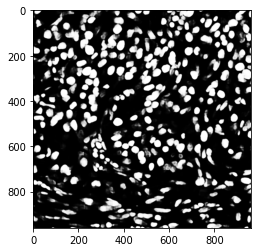

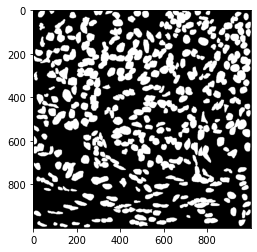

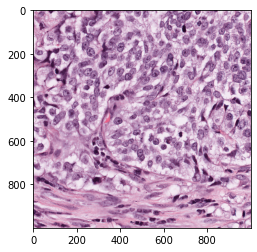

In [7]:


plt.imshow(sm_pred.squeeze().numpy(),cmap="gray")
plt.show()
plt.figure()
plt.imshow(sm_gt.squeeze(),cmap="gray")
plt.show()
plt.figure()
plt.imshow(tensor_to_numpy(img_orig))
plt.show()

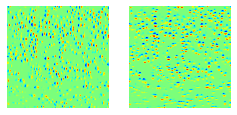

In [8]:
from src.vizualizations.image_viz import plot_images

plot_images(hv_pred,(1,2),vmin=-1,vmax=1,cmap="jet")
plt.show()

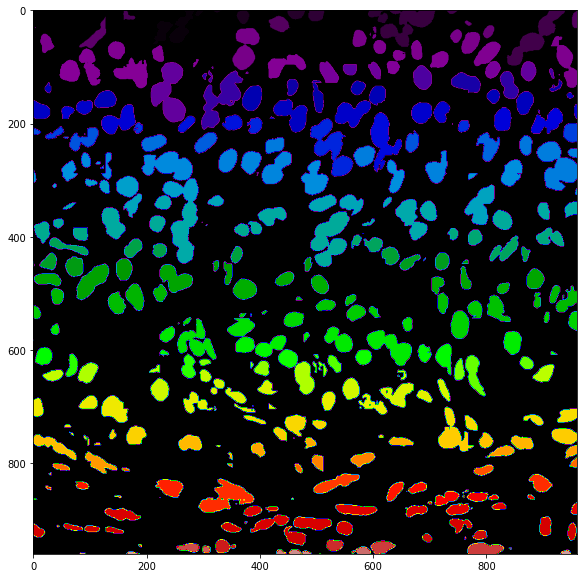

In [9]:
from src.transforms.graph_construction.hovernet_post_processing import hovernet_post_process

ins_pred = hovernet_post_process(sm_pred,hv_pred)
plt.figure(figsize=(10,10))
plt.imshow(ins_pred,cmap="nipy_spectral")
plt.show()

# Evaluation

In [10]:
from torch import Tensor
#def hollow(img:Tensor):#(H,W)
#    
#    output = img.clone()
#    def land_locked(r,c):
#        if r<=0 or r>=(img.shape[0]-1) or c<=0 or c>=(img.shape[1]-1):
#            return False
#        return (img[r,c]==img[r,c+1]==img[r,c-1]==img[r+1,c]==img[r-1,c]).item() & (img[r,c]!=0)
#    
#    stack = []
#    for row in tqdm(range(img.shape[0]),desc="Hollowing"):
#        for col in range(img.shape[1]):
#            stack.append((row,col))
#            while(len(stack)!=0):
#                (r,c) = stack.pop()
#                if(land_locked(r,c) and output[r,c]!=0):
#                    output[r,c]=0
#                    stack.append((r+1,c))
#                    stack.append((r-1,c))
#                    stack.append((r,c+1))
#                    stack.append((r,c-1))
#    return output

def hollow(img:Tensor):#(H,W)
    
    output = img.clone()
    def land_locked(r,c):
        if r<=0 or r>=(img.shape[0]-1) or c<=0 or c>=(img.shape[1]-1):
            return False
        return (img[r,c]==img[r,c+1]==img[r,c-1]==img[r+1,c]==img[r-1,c]).item() & (img[r,c]!=0)
    

    for row in tqdm(range(img.shape[0]),desc="Hollowing"):
        for col in range(img.shape[1]):
            if(land_locked(row,col)):
                output[row,col]=0

    return output


In [11]:
img_trans = img_orig[:,64:768+64,64:768+64]

In [12]:
print(t_img.shape)
sm_pred,hv_pred = predict_full_image(model,t_img,tile_size=128)


torch.Size([3, 1000, 1000])
1


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


In [13]:
from src.model.metrics.panoptic_quality import panoptic_quality

ins_gt_trans = ins_gt[0,64:768+64,64:768+64]
best=0
#for h_t in tqdm(range(1,10)):
#    for k_t in range(1,10):
#        h=h_t/10
#        k=k_t/10
#        ins_pred = hovernet_post_process(sm_pred,hv_pred,h=h,k=k)
#        pq = panoptic_quality(ins_pred,ins_gt_trans)
#        if best<pq:
#            print(pq,h,k)
#            best = pq

In [14]:
# H = 0.5, k=0.5

In [15]:
ins_pred = hovernet_post_process(sm_pred,hv_pred,h=0.5,k=0.5)
hl_pred = hollow(ins_pred)
hl_gt = hollow(ins_gt.squeeze())[64:768+64,64:768+64]
assert hl_gt.shape==hl_pred.shape

Hollowing: 100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


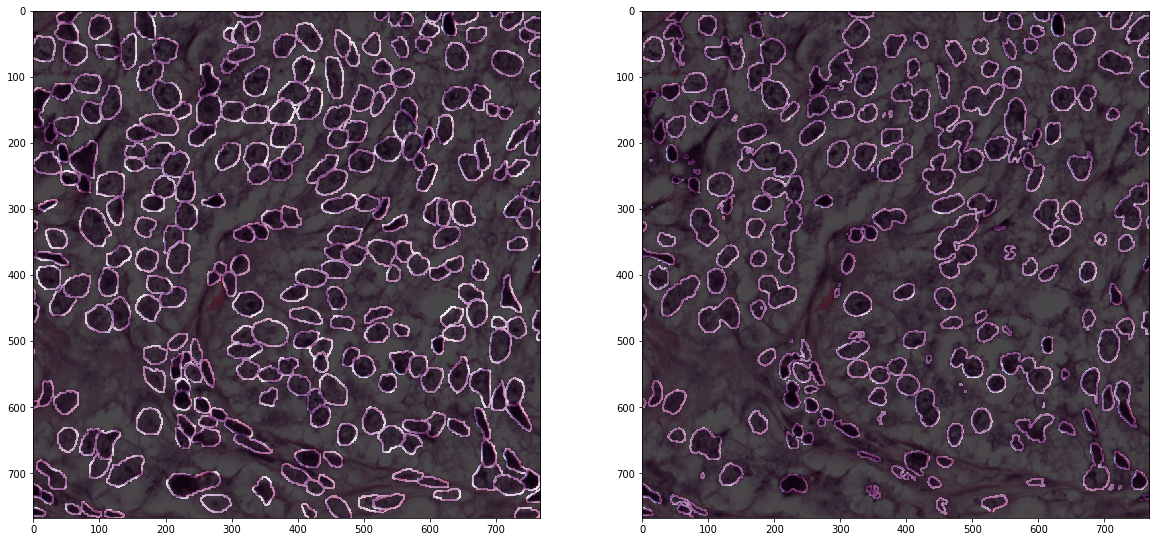

In [16]:
from numpy.ma import masked_where
f,ax = plt.subplots(1,2,figsize=(20,20))


ax[0].imshow(tensor_to_numpy(img_trans))
ax[0].imshow(masked_where(hl_gt!=0,hl_gt),cmap="nipy_spectral",alpha=0.7)
ax[1].imshow(tensor_to_numpy(img_trans))
ax[1].imshow(masked_where(hl_pred!=0,hl_pred),cmap="nipy_spectral",alpha=0.7)
plt.show()


# Constructing the Graph

In [17]:
from src.model.graph_construction.graph import Graph
from src.transforms.graph_construction.hover_maps import find_centre_of_mass
from torch_geometric.data import Data

def extract_graph(orig_img:Tensor,ins_seg:Tensor,window_size=70,k=6,dmin=150,model=None):
    nuclei = ins_seg.max()
    centres = []
    def out_of_view(x,y): #possible off by one error
        return (x<=window_size//2 or y<=window_size//2 or x>=ins_seg.shape[1]-window_size//2 or y>=ins_seg.shape[0]-window_size//2)
    
    # Check whats visible
    for i in range(1,nuclei+1):
        x,y = find_centre_of_mass(ins_seg,i)
        if(not out_of_view(x,y)):
            centres.append((x,y))
    
    # Perform KNN search
    def euclidean_dist(p1,p2):
        return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5
    
    edges_index = torch.zeros((2,0),dtype=torch.long)
    edge_attr = torch.zeros((0,1))
    for sr in range(len(centres)):
        closest = []
        for ds in range(len(centres)):
            if(sr!=ds and euclidean_dist(centres[sr],centres[ds])<dmin):
                closest.append((ds,euclidean_dist(centres[sr],centres[ds])))
        closest = sorted(closest,key=lambda x: x[1])[:min(k,len(closest))]
        for to,length in closest:
            edges_index = torch.cat((edges_index,torch.tensor([[sr,to],[to,sr]])),dim=1)
            edge_attr = torch.cat((edge_attr,torch.tensor([[length],[length]])),dim=0)
    

    # Perfrom Feature Extraction - NORMALIZE?
    feature_matrix_x = torch.zeros((0,window_size**2*3)) #as 3 channels
    position_matrix = torch.zeros((0,2))
    for x,y in centres:
        feature = orig_img[:,y-window_size//2:y+window_size//2,x-window_size//2:x+window_size//2].flatten()
        feature_matrix_x = torch.cat((feature_matrix_x,feature.unsqueeze(0)),dim=0)
        position_matrix = torch.cat((position_matrix,torch.tensor([[x,y]])),dim=0)
    output =  Data(x=feature_matrix_x,edge_index=edges_index,edge_attr=edge_attr)
    output.centres = position_matrix
    return output




In [18]:
g = extract_graph(img_trans,ins_pred)
print(g)

Data(x=[162, 14700], edge_index=[2, 1940], edge_attr=[1940, 1], centres=[162, 2])


# Concerns

Need to make sure sizes align as the tiling process clips sides